# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal/
!ls

In [ ]:
! pwd

# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import sys
import os
import copy
import math

import importlib

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from astropy.io  import fits
from astropy     import units as u
from astropy.wcs import WCS

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from spectral_cube import SpectralCube
from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

device:  cpu
device_count:  0


# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct101_checkpoint_path = checkpoint_path / 'c101'
ct256_checkpoint_path = checkpoint_path / 'c256_1split'
cnn101_checkpoint_path = checkpoint_path / 'cnn' / 'c101'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'

tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'

saury2014_data_path = data_path / 'saury'
seta222_data_path = data_path / 'seta'

# Utils

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)
    c = SpectralCube.read(dat)

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]

    dat.close()

    print(f"Cube shape: {c.shape}") # (vlsr, b, l)

    del dat

    _, _, x = c.world[0, 0, :]    # extract RA: deg
    _, y, _ = c.world[0, :, 0]    # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

In [ ]:
def m2fwhm(cube):
    #Velocity range and channel spacing
    vmin = -40 #km.s-1
    vmax = 40 #km.s-1

    dv = 0.3125 # 0.15625 # 0.8 #km.s-1
    # v = np.arange(vmin, vmax+dv, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
    v = np.arange(vmin, vmax, dv)

    # Calculate the moments
    # Compute Moment 0
    moment0 = np.sum(cube, axis=0) * dv

    # Compute Moment 1
    moment1 = np.sum(cube * v[:, None, None], axis=0) * dv / moment0

    # Compute Moment 2
    vdiff_squared = (v[:, None, None] - moment1)**2
    moment2 = np.sum(cube * vdiff_squared, axis=0) * dv / moment0

    sigma_m2 = np.sqrt(moment2)
    FWHM = sigma_m2 * np.sqrt(8.*np.log(2))
    return FWHM

# Read data

In [ ]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x nchan)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_2_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_1.0_K_beam_1.45_pix.fits'

training_data_file_q0 = os.path.join(saury2014_data_path, training_data_file_q0)
training_data_file_q1 = os.path.join(saury2014_data_path, training_data_file_q1)
training_data_file_q2 = os.path.join(saury2014_data_path, training_data_file_q2)
training_data_file_q3 = os.path.join(saury2014_data_path, training_data_file_q3)

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_2.fits'

rhi_file_q0 = os.path.join(saury2014_data_path, rhi_file_q0)
rhi_file_q1 = os.path.join(saury2014_data_path, rhi_file_q1)
rhi_file_q2 = os.path.join(saury2014_data_path, rhi_file_q2)
rhi_file_q3 = os.path.join(saury2014_data_path, rhi_file_q3)

# 3a. FCNM maps
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3.fits'

fcnm_file_q0 = os.path.join(saury2014_data_path, fcnm_file_q0)
fcnm_file_q1 = os.path.join(saury2014_data_path, fcnm_file_q1)
fcnm_file_q2 = os.path.join(saury2014_data_path, fcnm_file_q2)
fcnm_file_q3 = os.path.join(saury2014_data_path, fcnm_file_q3)

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)

# Spectal res: 1.0 km/s
# Channel spacing: 0.824 km/s

In [ ]:
training_data_file_q4 = 'Tb_mpism_sol_800_thick_256chan_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q4 = seta222_data_path / training_data_file_q4

tau_data_file_q4 = 'tau_mpism_sol_800_turb_thick_256chan_noise.fits'
tau_data_file_q4 = seta222_data_path / tau_data_file_q4

rhi_file_q4 = 'rhi_map_mpism_sol_800_Tcut_500K_thick_101chan.fits'
rhi_file_q4 = seta222_data_path / rhi_file_q4

fcnm_file_q4 = 'fcnm_map_mpism_sol_800_Tcut_500K.fits'
fcnm_file_q4 = seta222_data_path / fcnm_file_q4

# Training data set: Read data cube 1

In [ ]:
cube, header1 = fits.getdata(training_data_file_q0, header=True)
fcnm_data, header1 = fits.getdata(fcnm_file_q0, header=True)
rhi_data, header1 = fits.getdata(rhi_file_q0, header=True)

In [ ]:
# TB max
tbmax_map = np.max(cube, axis=0)

dv = 0.3125 # km/s
WHI = np.sum(cube, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

## $T_{b, peak}$

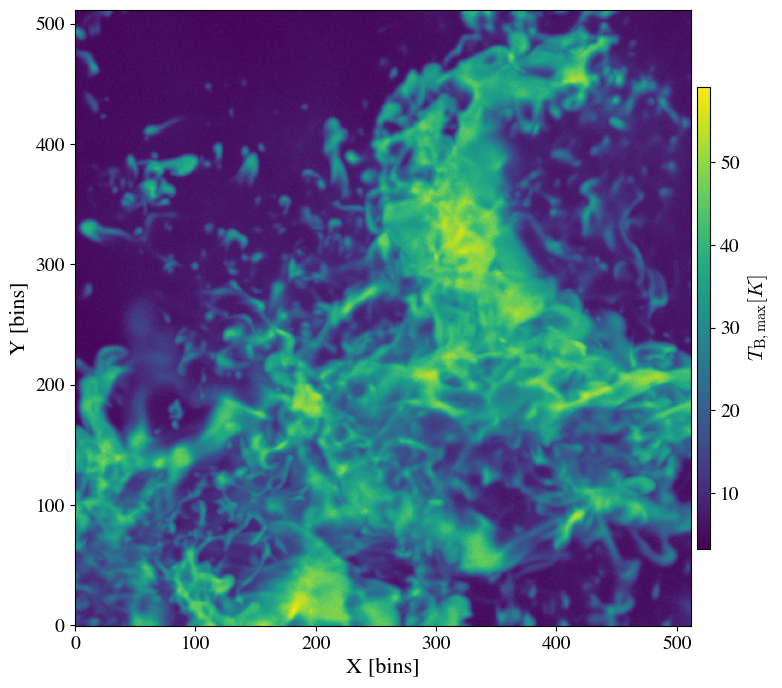

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(tbmax_map, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$T_\mathrm{B, max} [K]$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $N^{*}_{HI, thin}$

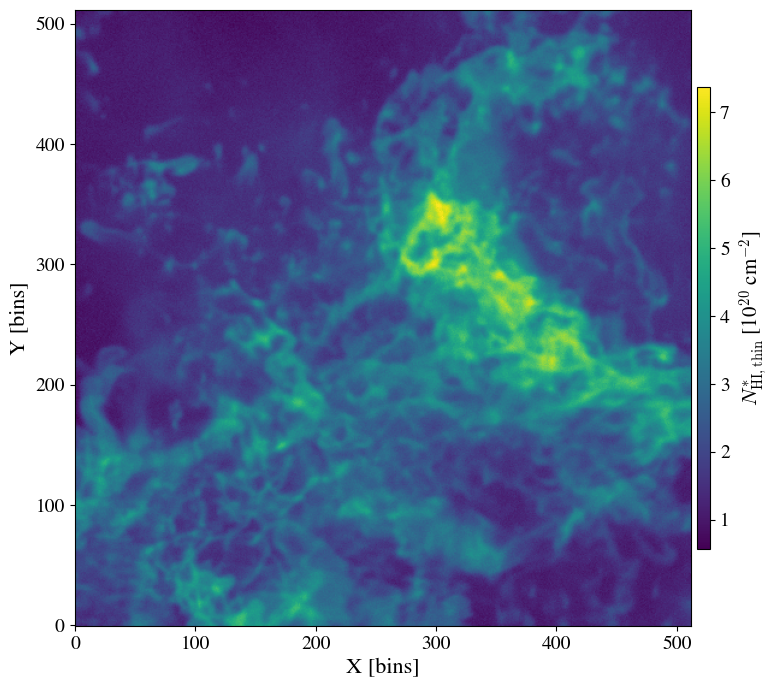

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(NHI_thin, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$N^{*}_\mathrm{HI,thin}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $F_{CNM}$

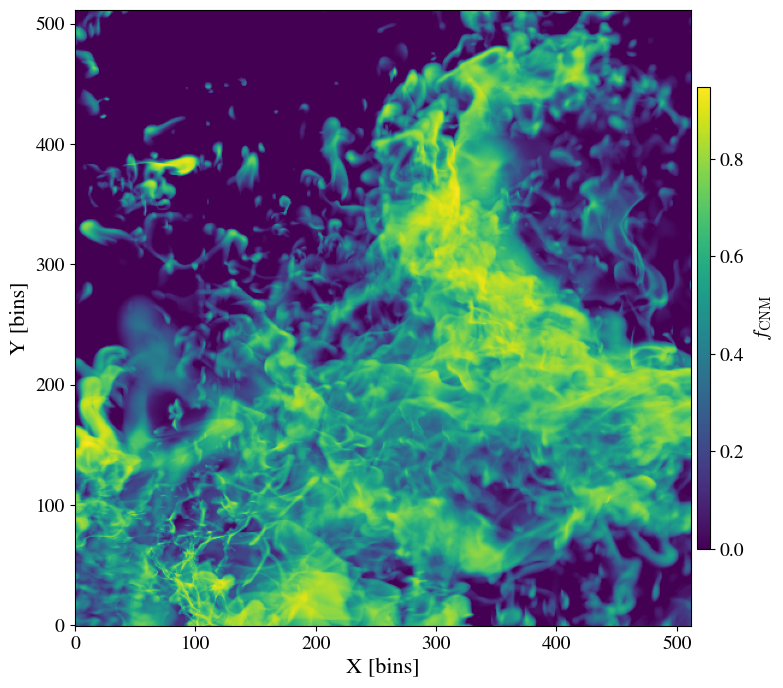

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(fcnm_data, cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $R_{HI}$

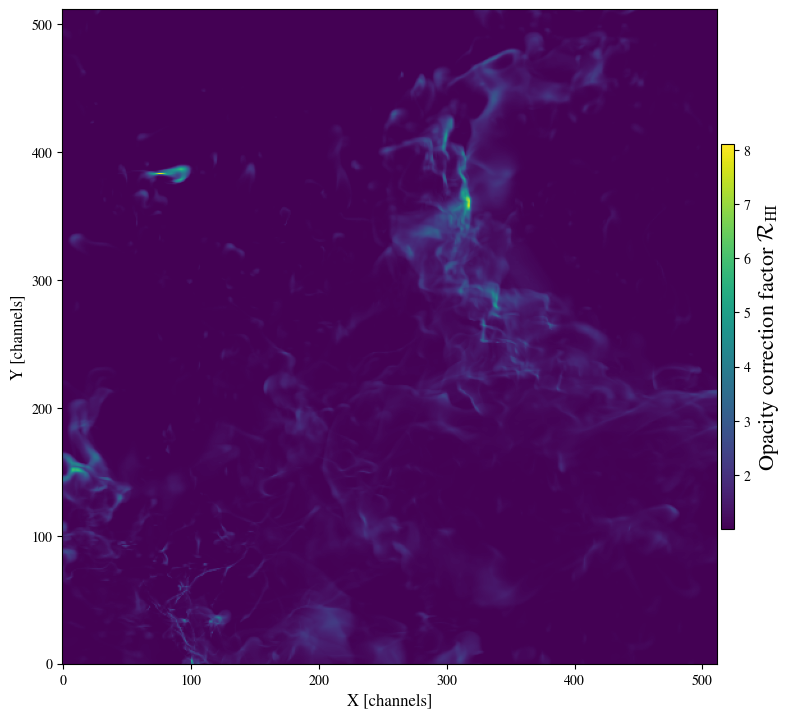

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(rhi_data, cmap='viridis', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Opacity correction factor $\mathcal{R}_\mathrm{HI}$', size=16)

plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

# Training data set: Read data cube 2

In [ ]:
cube, header1 = fits.getdata(training_data_file_q1, header=True)
fcnm_data, header1 = fits.getdata(fcnm_file_q1, header=True)
rhi_data, header1 = fits.getdata(rhi_file_q1, header=True)

In [ ]:
# TB max
tbmax_map = np.max(cube, axis=0)

dv = 0.3125 # km/s
WHI = np.sum(cube, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

## $T_{b, peak}$

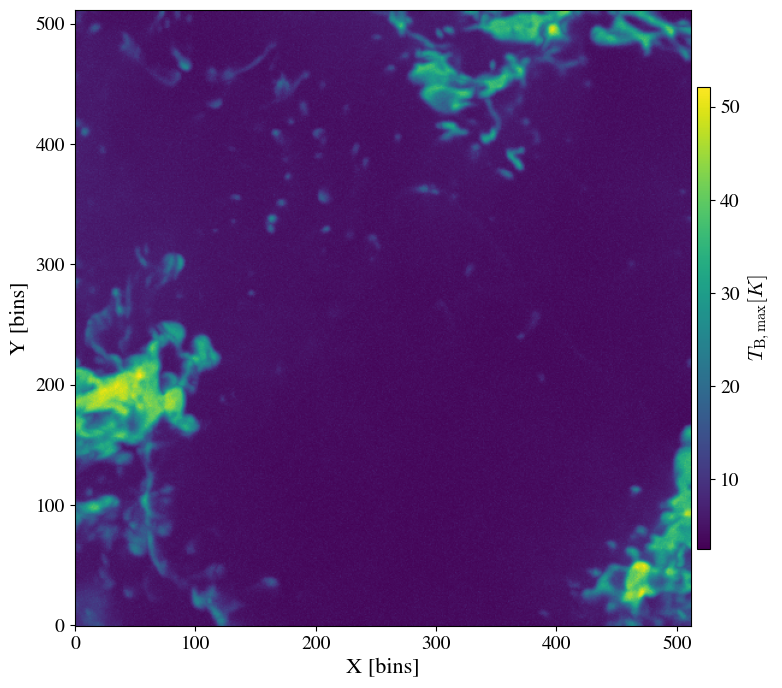

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(tbmax_map, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$T_\mathrm{B, max} [K]$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $N^{*}_{HI, thin}$

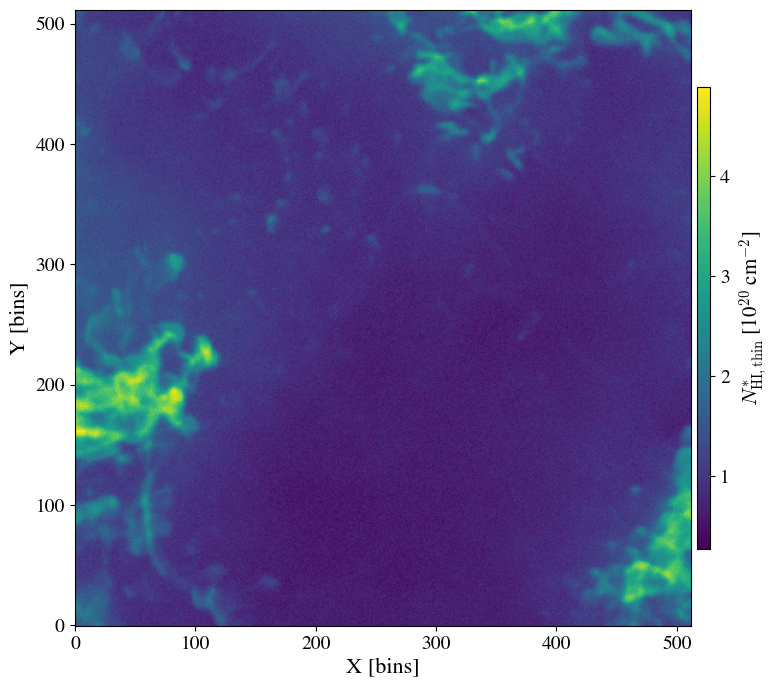

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(NHI_thin, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$N^{*}_\mathrm{HI,thin}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $F_{CNM}$

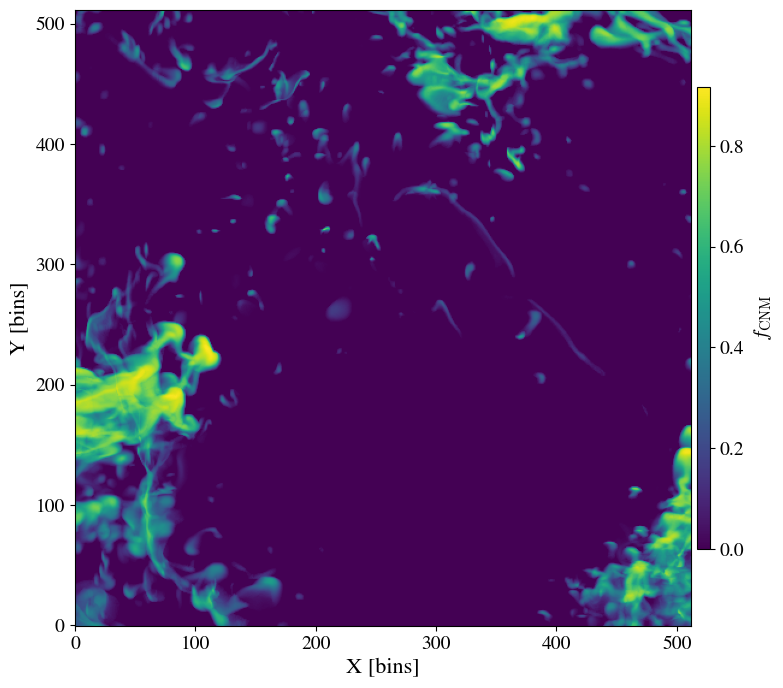

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(fcnm_data, cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $R_{HI}$

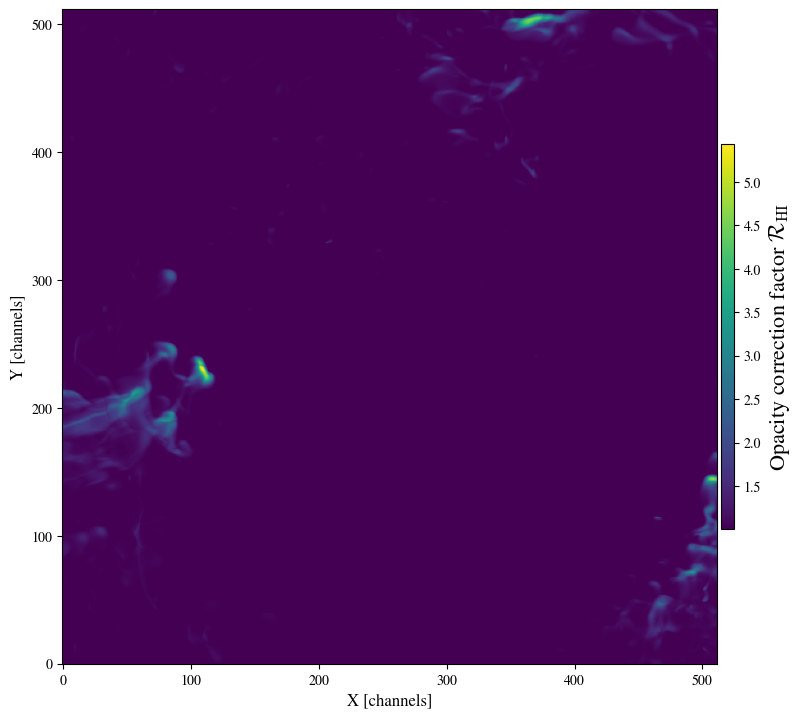

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(rhi_data, cmap='viridis', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Opacity correction factor $\mathcal{R}_\mathrm{HI}$', size=16)

plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

# Training data set: Read data cube 1

In [ ]:
cube, header1 = fits.getdata(training_data_file_q0, header=True)
fcnm_data, header1 = fits.getdata(fcnm_file_q0, header=True)
rhi_data, header1 = fits.getdata(rhi_file_q0, header=True)

In [ ]:
# TB max
tbmax_map = np.max(cube, axis=0)

dv = 0.3125 # km/s
WHI = np.sum(cube, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

## $T_{b, peak}$

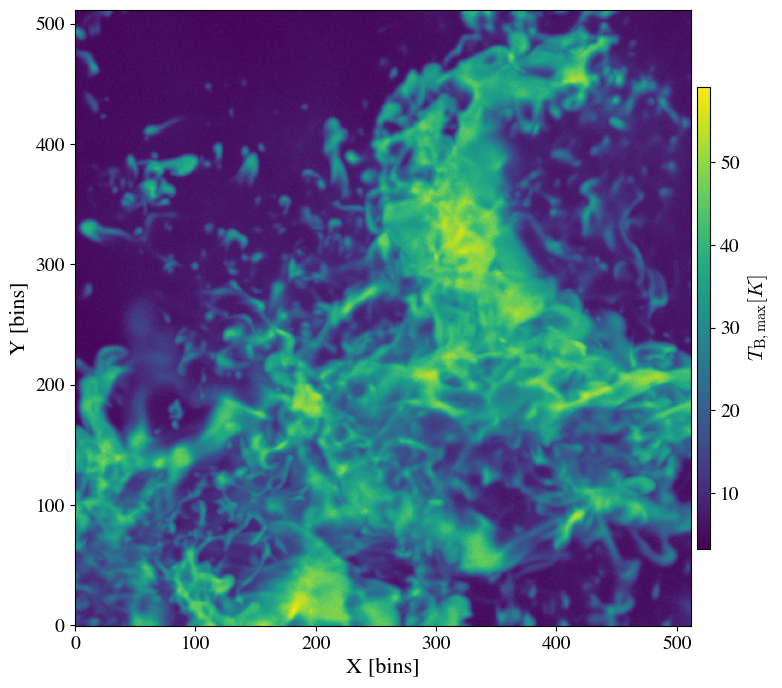

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(tbmax_map, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$T_\mathrm{B, max} [K]$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $N^{*}_{HI, thin}$

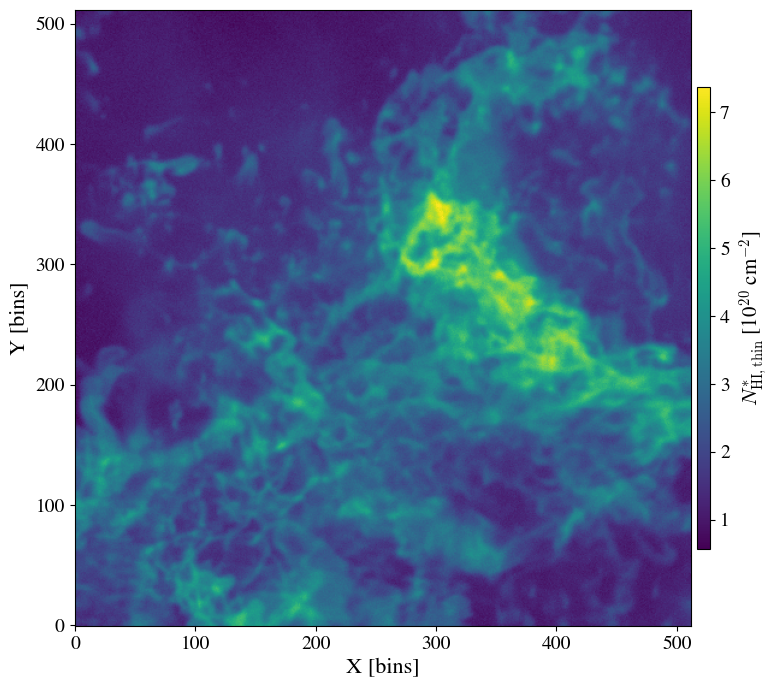

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(NHI_thin, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$N^{*}_\mathrm{HI,thin}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $F_{CNM}$

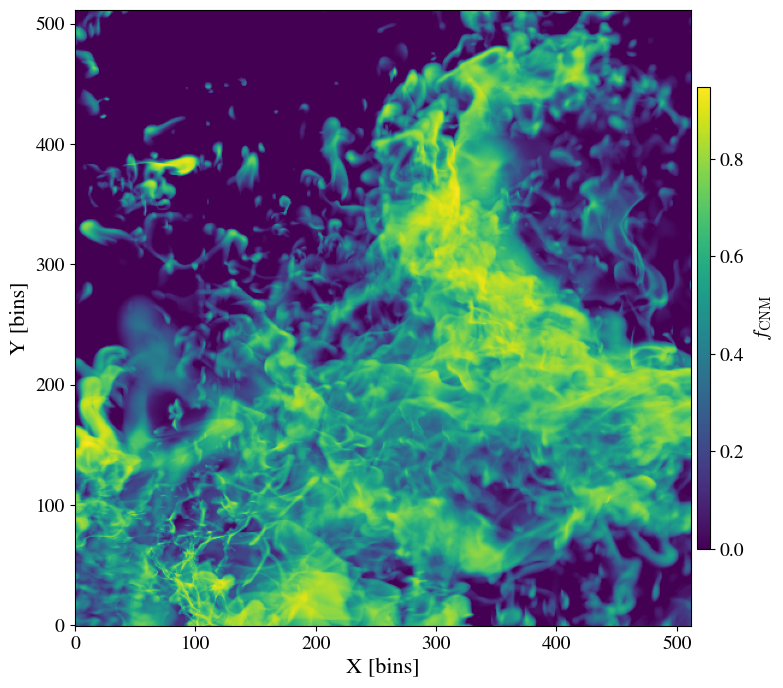

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(fcnm_data, cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $R_{HI}$

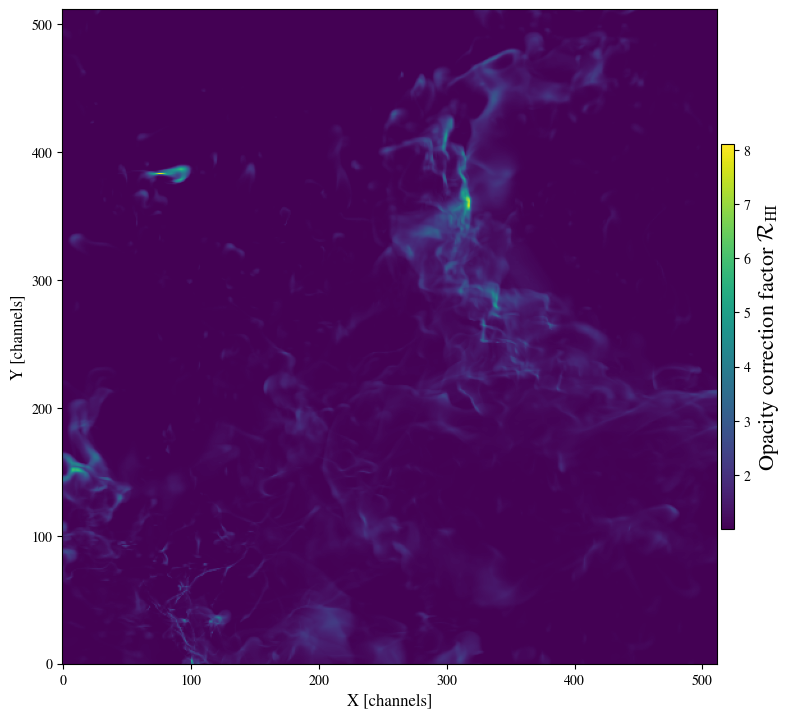

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(rhi_data, cmap='viridis', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Opacity correction factor $\mathcal{R}_\mathrm{HI}$', size=16)

plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

# Training data set: Read data cube 1

In [ ]:
cube, header1 = fits.getdata(training_data_file_q0, header=True)
fcnm_data, header1 = fits.getdata(fcnm_file_q0, header=True)
rhi_data, header1 = fits.getdata(rhi_file_q0, header=True)

In [ ]:
# TB max
tbmax_map = np.max(cube, axis=0)

dv = 0.3125 # km/s
WHI = np.sum(cube, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

## $T_{b, peak}$

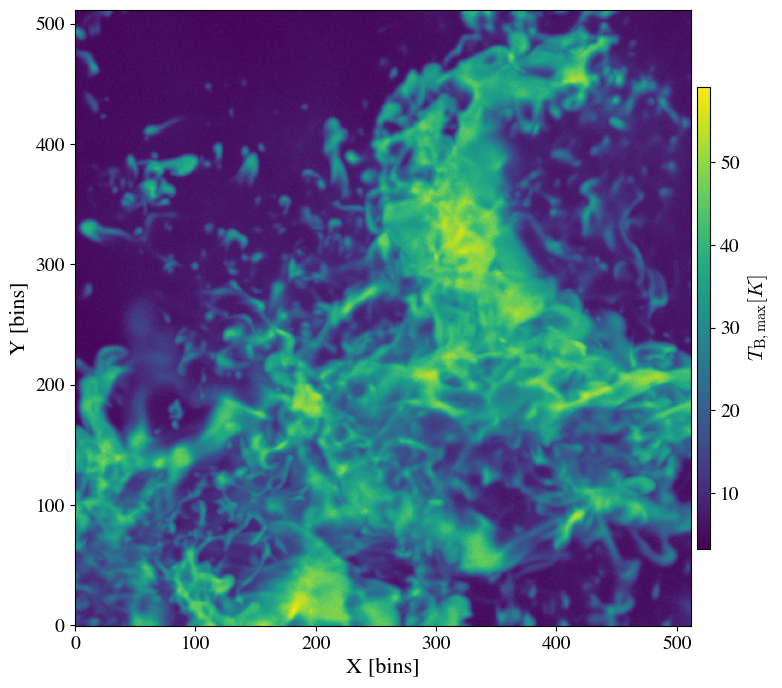

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(tbmax_map, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$T_\mathrm{B, max} [K]$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $N^{*}_{HI, thin}$

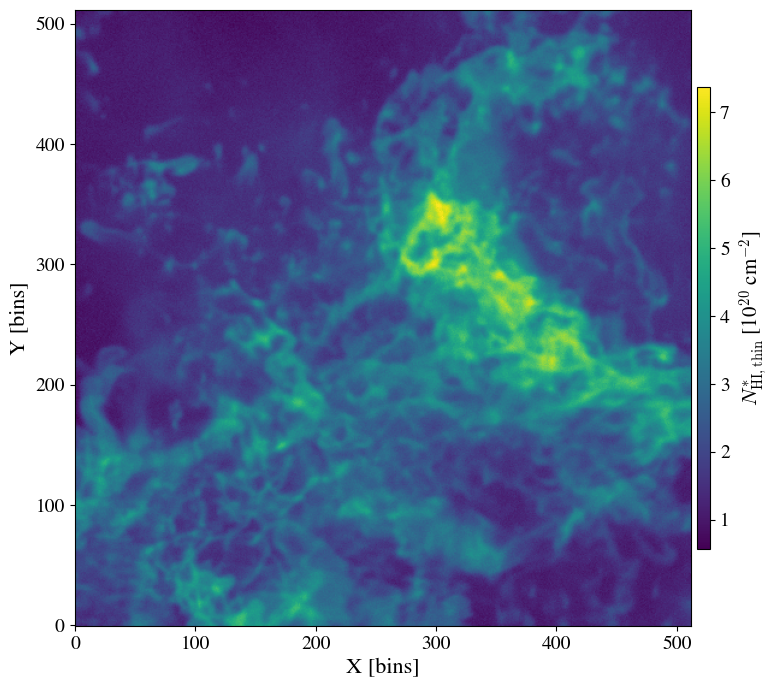

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(NHI_thin, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$N^{*}_\mathrm{HI,thin}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $F_{CNM}$

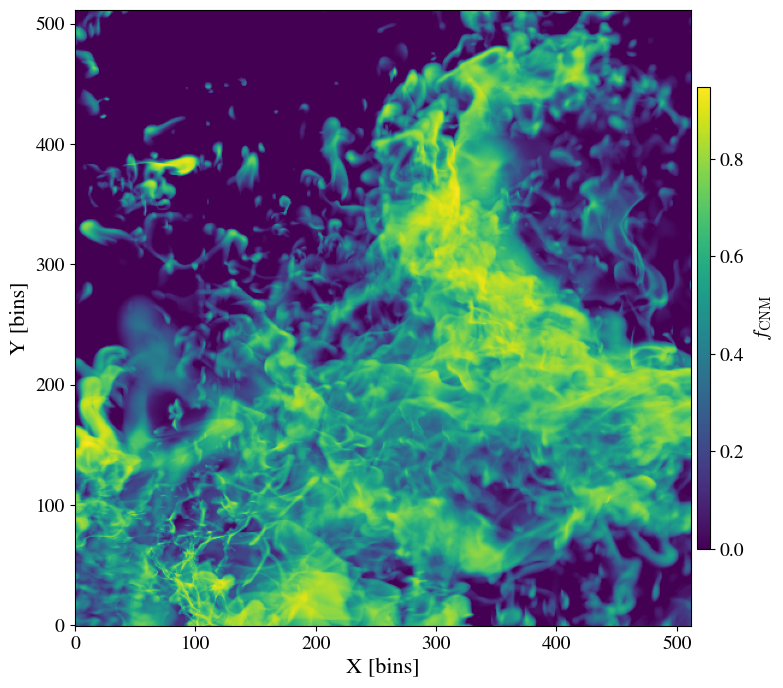

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(fcnm_data, cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## $R_{HI}$

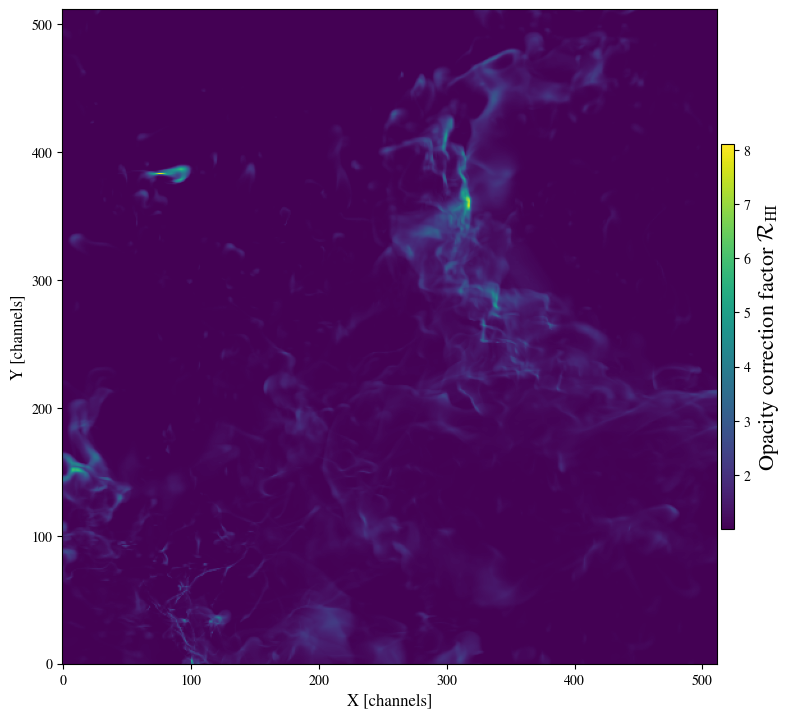

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(rhi_data, cmap='viridis', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Opacity correction factor $\mathcal{R}_\mathrm{HI}$', size=16)

plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()